In [63]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [64]:

import sys
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_columns", 100)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print("Versions:", {"python": sys.version.split()[0], "numpy": np.__version__, "pandas": pd.__version__})


Versions: {'python': '3.12.6', 'numpy': '2.3.2', 'pandas': '2.3.2'}


In [65]:
from pathlib import Path
import pandas as pd

def load_insurance_df(path: str | Path = "insurance.csv") -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(
            f"Файл не найден: {p.resolve()}."
        )
    print(f"Файл найден: {p.resolve()}")
    return pd.read_csv(p)

df = load_insurance_df("insurance.csv")
df.head()

Файл найден: /Users/mr-senkevich/Desktop/BSU/OIAD/oiad-11-2025/Senkevich/Lab_3/insurance.csv


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [66]:

display(df.head(10))
print("\nИнформация о типах и пропусках:")
print(df.info())
print("\nБазовые числовые статистики:")
display(df.describe(include=[np.number]).T)
print("\nЧисло строк и столбцов:", df.shape)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692



Информация о типах и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Базовые числовые статистики:


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801



Число строк и столбцов: (1338, 7)


Пропуски по столбцам:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64 

Число потенциальных выбросов по количественным признакам (IQR):
         age: 0
         bmi: 9
    children: 0
     charges: 139


/var/folders/qk/kzqy9lyn7lsbvq7_n5f2gh2c0000gn/T/ipykernel_8939/1652799252.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[c].dropna().values for c in num_cols], labels=num_cols, showmeans=True)


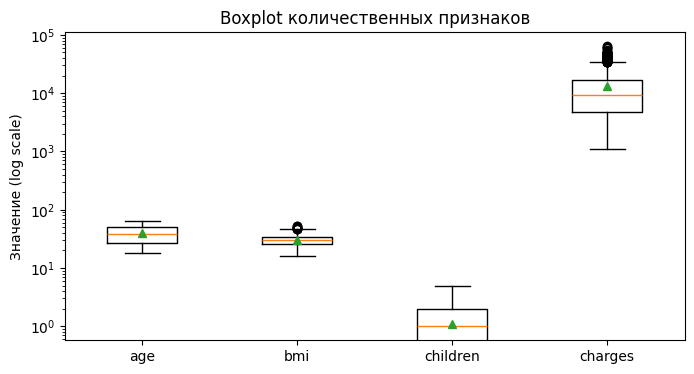

In [67]:
na_counts = df.isna().sum()
print("Пропуски по столбцам:\n", na_counts, "\n")

def iqr_bounds(s: pd.Series):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
outlier_report = {}
for col in num_cols:
    low, up = iqr_bounds(df[col])
    mask = (df[col] < low) | (df[col] > up)
    outlier_report[col] = int(mask.sum())

print("Число потенциальных выбросов по количественным признакам (IQR):")
for k, v in outlier_report.items():
    print(f"  {k:>10}: {v}")

fig = plt.figure(figsize=(8, 4))
plt.boxplot([df[c].dropna().values for c in num_cols], labels=num_cols, showmeans=True)
plt.title("Boxplot количественных признаков")
plt.ylabel("Значение (log scale)")
plt.yscale("log")
plt.show()


In [68]:

def binarize(series: pd.Series, true_val: str) -> pd.Series:
    return (series == true_val).astype(int)

def one_hot(df: pd.DataFrame, col: str, drop_first: bool = True) -> pd.DataFrame:
    cats = list(pd.unique(df[col]))
    cats_sorted = sorted(cats) 
    base = cats_sorted[0] if drop_first else None
    for cat in cats_sorted:
        if drop_first and cat == base:
            continue
        new_col = f"{col}__{cat}"
        df[new_col] = (df[col] == cat).astype(int)
    return df.drop(columns=[col])

df_enc = df.copy()
# бинарные
if "sex" in df_enc.columns:
    df_enc["sex"] = binarize(df_enc["sex"].astype(str).str.lower(), "male")  # male->1, female->0
if "smoker" in df_enc.columns:
    df_enc["smoker"] = binarize(df_enc["smoker"].astype(str).str.lower(), "yes")  # yes->1, no->0

# номинальные
if "region" in df_enc.columns:
    df_enc = one_hot(df_enc, "region", drop_first=True)

print("Столбцы после кодирования:")
print(df_enc.columns.tolist())
display(df_enc.head())


Столбцы после кодирования:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region__northwest', 'region__southeast', 'region__southwest']


,age,sex,bmi,children,smoker,charges,region__northwest,region__southeast,region__southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


,age,sex,bmi,children,smoker,charges,region__northwest,region__southeast,region__southwest
age,1.000,-0.021,0.109,0.042,-0.025,0.299,-0.000,-0.012,0.010
sex,-0.021,1.000,0.046,0.017,0.076,0.057,-0.011,0.017,-0.004
bmi,0.109,0.046,1.000,0.013,0.004,0.198,-0.136,0.270,-0.006
children,0.042,0.017,0.013,1.000,0.008,0.068,0.025,-0.023,0.022
smoker,-0.025,0.076,0.004,0.008,1.000,0.787,-0.037,0.068,-0.037
charges,0.299,0.057,0.198,0.068,0.787,1.000,-0.040,0.074,-0.043
region__northwest,-0.000,-0.011,-0.136,0.025,-0.037,-0.040,1.000,-0.346,-0.321
region__southeast,-0.012,0.017,0.270,-0.023,0.068,0.074,-0.346,1.000,-0.346
region__southwest,0.010,-0.004,-0.006,0.022,-0.037,-0.043,-0.321,-0.346,1.000


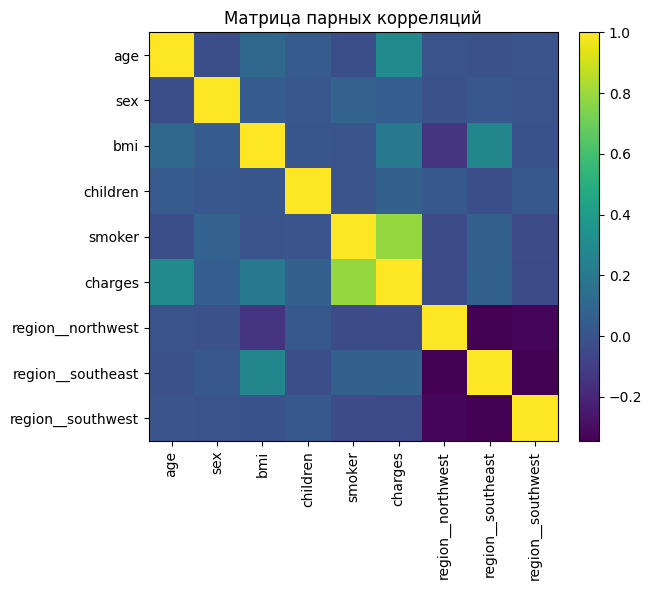


Топ-5 признаков по |corr(., charges)|:


charges              1.000000
smoker               0.787251
age                  0.299008
bmi                  0.198341
region__southeast    0.073982
children             0.067998
Name: charges, dtype: float64

In [69]:

corr = df_enc.corr(numeric_only=True)
display(corr.round(3))

fig = plt.figure(figsize=(7, 6))
im = plt.imshow(corr.values, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Матрица парных корреляций")
plt.tight_layout()
plt.show()

if "charges" in corr.columns:
    abs_corr = corr["charges"].abs().sort_values(ascending=False)
    print("\nТоп-5 признаков по |corr(., charges)|:")
    display(abs_corr.head(6))  # включая сам charges


In [70]:
target_col = "charges"
feature_cols = [c for c in df_enc.columns if c != target_col]
X_full = df_enc[feature_cols].to_numpy(dtype=float)
y_full = df_enc[target_col].to_numpy(dtype=float)

def train_test_split(X, y, test_size=0.2, seed=RANDOM_SEED):
    n = X.shape[0]
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    test_n = int(round(n * test_size))
    test_idx = idx[:test_n]
    train_idx = idx[test_n:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, seed=RANDOM_SEED)

def fit_standard_scaler(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0  # защита от деления на 0
    return mu, sigma

def transform_standard(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = fit_standard_scaler(X_train)
X_train_s = transform_standard(X_train, mu, sigma)
X_test_s  = transform_standard(X_test,  mu, sigma)

def add_intercept(X):
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([ones, X])

Xtr = add_intercept(X_train_s)
Xte = add_intercept(X_test_s)

print("Формы матриц:", {"Xtr": Xtr.shape, "Xte": Xte.shape, "y_train": y_train.shape, "y_test": y_test.shape})


Формы матриц: {'Xtr': (1070, 9), 'Xte': (268, 9), 'y_train': (1070,), 'y_test': (268,)}


## 2.1 Аналитическое решение

Модель $f(x, w) = Xw$. Функционал $$Q(w) = \lVert Xw - y\rVert^2.$$  
Градиент: $\frac{\partial Q}{\partial w} = 2 X^\top (Xw - y)$.  
Приравнивая к нулю, получаем **нормальные уравнения**:  
$$X^\top X \, w = X^\top y \quad \Rightarrow \quad w^* = (X^\top X)^{-1} X^\top y.$$


In [71]:

def gauss_jordan_inverse(A: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    A = A.astype(float).copy()
    n = A.shape[0]
    I = np.eye(n, dtype=float)
    for col in range(n):
        # выбор ведущего элемента (pivot) — частичный выбор максимума по столбцу
        pivot_row = col + np.argmax(np.abs(A[col:, col]))
        if abs(A[pivot_row, col]) < eps:
            raise ValueError("Матрица плохо обусловлена или вырожденная; инверсия невозможна.")
        # перестановка строк
        if pivot_row != col:
            A[[col, pivot_row]] = A[[pivot_row, col]]
            I[[col, pivot_row]] = I[[pivot_row, col]]
        # нормируем ведущую строку
        pivot = A[col, col]
        A[col, :] /= pivot
        I[col, :] /= pivot
        # зануляем остальные элементы в столбце
        for row in range(n):
            if row == col:
                continue
            factor = A[row, col]
            if factor != 0.0:
                A[row, :] -= factor * A[col, :]
                I[row, :] -= factor * I[col, :]
    return I

def ols_closed_form(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Оценка OLS по формуле w = (X^T X)^{-1} X^T y"""
    XtX = X.T @ X
    XtX_inv = gauss_jordan_inverse(XtX)
    Xty = X.T @ y
    return XtX_inv @ Xty

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    diff = y_true - y_pred
    return float(np.mean(diff * diff))

w_ols_cf = ols_closed_form(Xtr, y_train)
y_pred_train_cf = Xtr @ w_ols_cf
y_pred_test_cf  = Xte @ w_ols_cf

print("w (аналитически, OLS):", w_ols_cf.round(4))
print("MSE (train) =", round(mse(y_train, y_pred_train_cf), 4))
print("MSE (test)  =", round(mse(y_test,  y_pred_test_cf),  4))


w (аналитически, OLS): [13344.7733  3676.6376   -43.3335  2196.7132   586.3966  9699.0984
  -112.3088  -482.8615  -436.3602]
MSE (train) = 38040320.902
MSE (test)  = 30540365.2237



## 2.2 Численное решение — градиентный спуск *(реализовать самому)*

**Теория:** классический градиентный спуск:  
$$w^{(k+1)} = w^{(k)} - \lambda \cdot \nabla Q(w^{(k)}), \quad
\nabla Q(w) = 2 X^\top (Xw - y).$$

Мы используем **батч-версию** (градиент по всей выборке). Масштабирование признаков выше помогает устойчивой сходимости.


Остановка по малому изменению весов на итерации 739
w (градиентный спуск, OLS): [13344.7733  3676.6376   -43.3335  2196.7132   586.3966  9699.0984
  -112.3088  -482.8615  -436.3602]


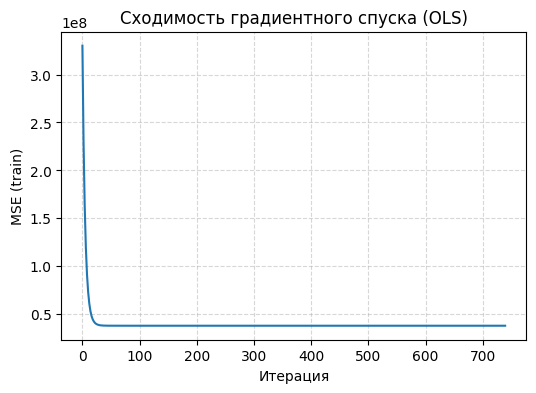

MSE (train, GD) = 38040320.902
MSE (test,  GD) = 30540365.2237


In [72]:

def l2_norm(v: np.ndarray) -> float:
    return float(np.sqrt(np.sum(v*v)))

def ols_gradient_descent(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 0.05,
    max_iter: int = 20_000,
    tol: float = 1e-8,
    verbose: bool = True
):
    """Градиентный спуск для OLS. Возвращает веса и историю потерь."""
    m, n = X.shape
    w = np.zeros(n, dtype=float)
    history = []
    for k in range(max_iter):
        y_pred = X @ w
        # делим на m, чтобы шаг обучения не зависел от размера сэмпла
        grad = (2.0 / m) * (X.T @ (y_pred - y))
        w_new = w - lr * grad
        loss = mse(y, y_pred)
        history.append(loss)
        if l2_norm(w_new - w) < tol:
            if verbose:
                print(f"Остановка по малому изменению весов на итерации {k}")
            w = w_new
            break
        w = w_new
    return w, history

w_ols_gd, hist_ols = ols_gradient_descent(Xtr, y_train, lr=0.05, max_iter=20000, tol=1e-9, verbose=True)
print("w (градиентный спуск, OLS):", w_ols_gd.round(4))

plt.figure(figsize=(6,4))
plt.plot(hist_ols)
plt.xlabel("Итерация")
plt.ylabel("MSE (train)")
plt.title("Сходимость градиентного спуска (OLS)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

y_pred_train_gd = Xtr @ w_ols_gd
y_pred_test_gd  = Xte @ w_ols_gd
print("MSE (train, GD) =", round(mse(y_train, y_pred_train_gd), 4))
print("MSE (test,  GD) =", round(mse(y_test,  y_pred_test_gd),  4))


## 3.1 Аналитическое решение
Регуляризованный функционал:
$$Q_{L_2}(w) = \lVert Xw - y\rVert^2 + \alpha \lVert w\rVert_2^2.$$
Его аналитическое решение:
$$w^* = (X^\top X + \alpha I)^{-1} X^\top y.$$
Градиент:
$$\frac{\partial Q_{L_2}}{\partial w} = 2 X^\top (Xw - y) + 2\alpha w.$$


In [73]:

def ridge_closed_form(X: np.ndarray, y: np.ndarray, alpha: float, penalize_intercept: bool = False) -> np.ndarray:
    """Аналитическое решение Ridge: w = (X^T X + alpha * A)^(-1) X^T y,
    где A = I или diag([0,1,1,...]) если не штрафуем w0.
    Инверсия — методом Гаусса–Жордана.
    """
    n = X.shape[1]
    A = np.eye(n, dtype=float)
    if not penalize_intercept:
        A[0, 0] = 0.0  # не штрафуем w0
    XtX = X.T @ X
    XtX_reg = XtX + alpha * A
    XtX_reg_inv = gauss_jordan_inverse(XtX_reg)
    Xty = X.T @ y
    return XtX_reg_inv @ Xty

alpha_demo = 1.0
w_ridge_cf_demo = ridge_closed_form(Xtr, y_train, alpha=alpha_demo, penalize_intercept=False)
print("Демо-веса Ridge (alpha=1.0):", w_ridge_cf_demo.round(4))

y_pred_test_ridge_demo = Xte @ w_ridge_cf_demo
print("Demo MSE (test, Ridge alpha=1.0):", round(mse(y_test, y_pred_test_ridge_demo), 4))


Демо-веса Ridge (alpha=1.0): [13344.7733  3673.4249   -42.8778  2194.6002   586.2006  9689.9203
  -111.9004  -480.9302  -435.2667]
Demo MSE (test, Ridge alpha=1.0): 30536414.6312


Лучшая alpha по валидации: 31.622776601683793   с MSE(val) = 51204260.4822


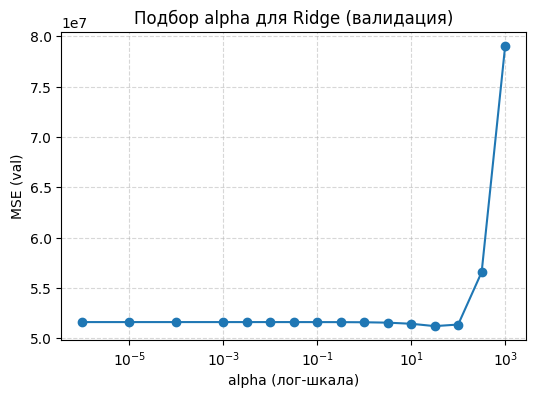

MSE (train, Ridge CF) = 38134587.5487
MSE (test,  Ridge CF) = 30496269.316


In [74]:

def simple_split_train_val(X, y, val_size=0.2, seed=RANDOM_SEED):
    m = X.shape[0]
    idx = np.arange(m)
    rng = np.random.default_rng(seed + 1) 
    rng.shuffle(idx)
    val_n = int(round(m * val_size))
    val_idx = idx[:val_n]
    tr_idx = idx[val_n:]
    return X[tr_idx], X[val_idx], y[tr_idx], y[val_idx]

X_tr_sub, X_val, y_tr_sub, y_val = simple_split_train_val(Xtr, y_train, val_size=0.2, seed=RANDOM_SEED)

alphas = np.concatenate([np.array([1e-6, 1e-5, 1e-4]), np.logspace(-3, 3, 13)])
val_scores = []
for a in alphas:
    w = ridge_closed_form(X_tr_sub, y_tr_sub, alpha=a, penalize_intercept=False)
    y_val_pred = X_val @ w
    val_scores.append(mse(y_val, y_val_pred))

best_idx = int(np.argmin(val_scores))
best_alpha = float(alphas[best_idx])
print("Лучшая alpha по валидации:", best_alpha, "  с MSE(val) =", round(val_scores[best_idx], 4))

# график MSE(val) по alpha (лог-шкала)
plt.figure(figsize=(6,4))
plt.semilogx(alphas, val_scores, marker="o")
plt.xlabel("alpha (лог-шкала)")
plt.ylabel("MSE (val)")
plt.title("Подбор alpha для Ridge (валидация)")
plt.grid(True, linestyle="--", which="both", alpha=0.5)
plt.show()

# финальная модель на всём train с best_alpha
w_ridge_cf = ridge_closed_form(Xtr, y_train, alpha=best_alpha, penalize_intercept=False)
y_pred_train_ridge_cf = Xtr @ w_ridge_cf
y_pred_test_ridge_cf  = Xte @ w_ridge_cf
print("MSE (train, Ridge CF) =", round(mse(y_train, y_pred_train_ridge_cf), 4))
print("MSE (test,  Ridge CF) =", round(mse(y_test,  y_pred_test_ridge_cf),  4))


iter 1900: loss↑ or non-finite; reduce lr -> 6.1e-07
Остановка по малому шагу на итерации 1902
w (Ridge, GD): [13344.7733  3577.5751   -29.7063  2132.2857   580.0593  9417.0903
  -101.4413  -426.1412  -404.707 ]


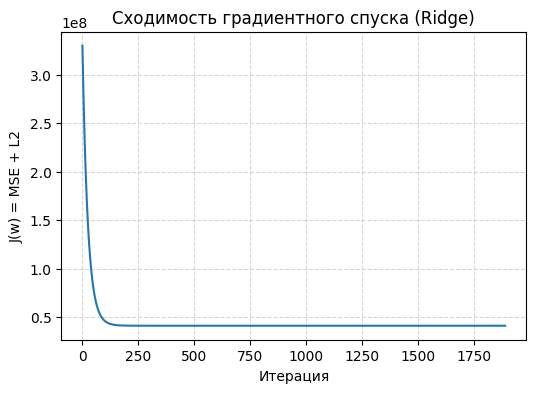

MSE (train, Ridge GD) = 38134587.6015
MSE (test,  Ridge GD) = 30496269.2753


In [75]:
def ridge_gradient_descent(
    X: np.ndarray,
    y: np.ndarray,
    alpha: float,
    lr: float = 0.01,         
    max_iter: int = 30_000,
    tol: float = 1e-8,
    tol_grad: float = 1e-6,   
    grad_clip: float = 1e6,    
    penalize_intercept: bool = False,
    verbose: bool = True
):
    """
    Оптимизируем усреднённую цель:
        J(w) = (1/m)*||Xw - y||^2 + (alpha/m)*||w'||^2,
    где w' = w с нулём на позиции интерсепта (если penalize_intercept=False).
    Тогда:
        grad = (2/m)*X^T(Xw - y) + 2*(alpha/m)*w'.
    """
    m, n = X.shape
    w = np.zeros(n, dtype=float)
    history = []

    def loss_and_grad(w):
        y_pred = X @ w
        resid = y_pred - y
        # усреднённый MSE
        data_loss = float(np.mean(resid * resid))
        # рег. вектор (не штрафуем w0)
        reg_vec = w.copy()
        if not penalize_intercept:
            reg_vec[0] = 0.0
        reg_loss = float((alpha / m) * np.dot(reg_vec, reg_vec))
        J = data_loss + reg_loss

        grad_data = (2.0 / m) * (X.T @ resid)
        grad = grad_data + 2.0 * (alpha / m) * reg_vec
        return J, grad, y_pred

    J, g, y_pred = loss_and_grad(w)
    history.append(J)

    for k in range(max_iter):
        # клиппинг градиента
        g_norm = float(np.linalg.norm(g))
        if g_norm > grad_clip:
            g = g * (grad_clip / g_norm)

        w_new = w - lr * g
        if not np.all(np.isfinite(w_new)):
            lr *= 0.5
            if verbose:
                print(f"iter {k}: non-finite w; reduce lr -> {lr:.3g}")
            continue

        J_new, g_new, y_pred_new = loss_and_grad(w_new)

        # backtracking: если хуже — уменьшаем шаг и пробуем снова (без инкремента итерации)
        if not np.isfinite(J_new) or J_new > J:
            lr *= 0.5
            if verbose and (k % 100 == 0):
                print(f"iter {k}: loss↑ or non-finite; reduce lr -> {lr:.3g}")
            continue

        step_norm = float(np.linalg.norm(w_new - w))
        w, J, g, y_pred = w_new, J_new, g_new, y_pred_new
        history.append(J)

        # критерии остановки
        if step_norm < tol:
            if verbose:
                print(f"Остановка по малому шагу на итерации {k}")
            break
        if float(np.linalg.norm(g)) < tol_grad:
            if verbose:
                print(f"Остановка по малой норме градиента на итерации {k}")
            break

    return w, history

w_ridge_gd, hist_ridge = ridge_gradient_descent(
    Xtr, y_train,
    alpha=best_alpha,
    lr=0.01,                
    max_iter=30000,
    tol=1e-9,
    penalize_intercept=False,
    verbose=True
)

print("w (Ridge, GD):", w_ridge_gd.round(4))

plt.figure(figsize=(6,4))
plt.plot(hist_ridge)
plt.xlabel("Итерация")
plt.ylabel("J(w) = MSE + L2")  
plt.title("Сходимость градиентного спуска (Ridge)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

y_pred_train_ridge_gd = Xtr @ w_ridge_gd
y_pred_test_ridge_gd  = Xte @ w_ridge_gd
print("MSE (train, Ridge GD) =", round(np.mean((y_train - y_pred_train_ridge_gd)**2), 4))
print("MSE (test,  Ridge GD) =", round(np.mean((y_test  - y_pred_test_ridge_gd )**2), 4))

,Модель,MSE (test)
0,Ridge — градиентный спуск (alpha=31.62),3.049627e+07
1,Ridge — аналитическое (alpha=31.62),3.049627e+07
2,OLS — градиентный спуск,3.054037e+07
3,OLS — аналитическое решение,3.054037e+07
4,Константная (среднее по train),1.250804e+08


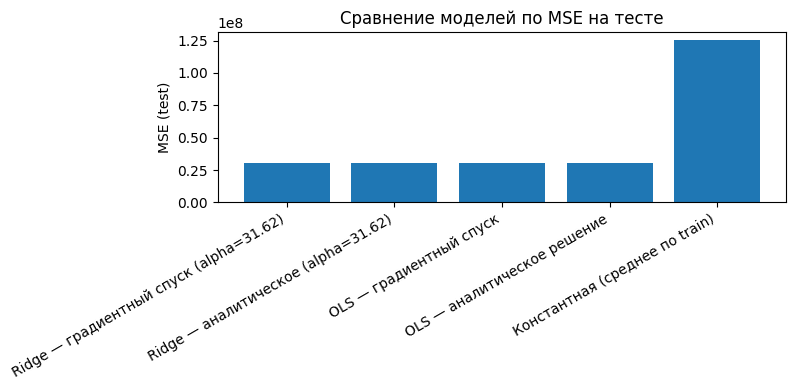

In [76]:
# Оценки

# 1) Константная модель
y_mean = float(np.mean(y_train))
y_pred_test_const = np.full_like(y_test, fill_value=y_mean, dtype=float)
mse_const = mse(y_test, y_pred_test_const)

# 2) Линейная OLS
mse_ols_cf = mse(y_test, Xte @ w_ols_cf)
mse_ols_gd = mse(y_test, Xte @ w_ols_gd)

# 3) Ridge
mse_ridge_cf = mse(y_test, Xte @ w_ridge_cf)
mse_ridge_gd = mse(y_test, Xte @ w_ridge_gd)

summary = pd.DataFrame({
    "Модель": [
        "Константная (среднее по train)",
        "OLS — аналитическое решение",
        "OLS — градиентный спуск",
        f"Ridge — аналитическое (alpha={best_alpha:.4g})",
        f"Ridge — градиентный спуск (alpha={best_alpha:.4g})",
    ],
    "MSE (test)": [mse_const, mse_ols_cf, mse_ols_gd, mse_ridge_cf, mse_ridge_gd],
}).sort_values("MSE (test)").reset_index(drop=True)

display(summary)

# Небольшая визуализация для сравнения
plt.figure(figsize=(8,4))
plt.bar(summary["Модель"], summary["MSE (test)"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("MSE (test)")
plt.title("Сравнение моделей по MSE на тесте")
plt.tight_layout()
plt.show()
